In [72]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

Define target log prob (we'll do the Rosenbrock function as a toy example)

In [84]:
# input theta has shape (n_walkers, n_parameters), output has shape (n_walkers,)
@tf.function
def log_prob(theta):
    
    # seperate out parameters
    x, y = tf.split(theta, (1,1), axis=-1)
    
    # rosenbrock function
    return -tf.squeeze(tf.divide(tf.square(1. - x) + tf.multiply(100., tf.square(y - tf.square(x))), 20.), -1)

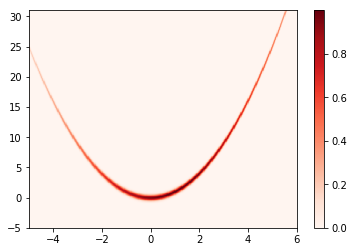

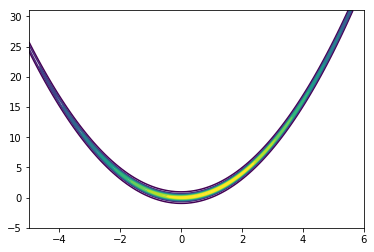

In [125]:
# plot the target log prob so we know what we're dealing with in this toy example...

# grid...
x = np.linspace(-5, 6, 500).astype(np.float32)
y = np.linspace(-5, 31, 500).astype(np.float32)
X, Y = np.meshgrid(x, y)
grid = tf.stack([X, Y], axis=-1)

# log prob..
L = tf.exp(log_prob(grid)).numpy()

# plot...
plt.pcolormesh(x, y, L, cmap='Reds')
plt.colorbar()
plt.show()

plt.contour(x, y, L, levels = np.array([0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])*np.max(L.flatten()).astype(np.float64))
plt.show()

Affine sampling

In [99]:
# number of parameters
n_params = 2

# number of walkers
n_walkers = 500

# number of MCMC steps to take
n_steps = 300

# initialize walkers...
walkers1 = tf.random.normal([n_walkers, 2], 0., 1.)
walkers2 = tf.random.normal([n_walkers, 2], 0., 1.)
current_state1 = tf.Variable(walkers1)
current_state2 = tf.Variable(walkers2)

# initial target log prob for the walkers (and set any nans to -inf)...
logp_current1 = log_prob(current_state1)
logp_current2 = log_prob(current_state2)
logp_current1 = tf.where(tf.math.is_nan(logp_current1), tf.ones_like(logp_current1)*tf.math.log(0.), logp_current1)
logp_current2 = tf.where(tf.math.is_nan(logp_current2), tf.ones_like(logp_current2)*tf.math.log(0.), logp_current2)

# holder for the whole chain
chain = [tf.concat([current_state1, current_state2], axis=0)]

# MCMC loop
with trange(1, n_steps) as t:
    for epoch in t:
        
        # first set of walkers:
    
        # proposals
        partners1 = tf.gather(current_state2, np.random.randint(0, n_walkers, n_walkers))
        z1 = 0.5*(tf.random.uniform([n_walkers], minval=0, maxval=1)+1)**2
        proposed_state1 = partners1 + tf.transpose(z1*tf.transpose(current_state1 - partners1))

        # target log prob at proposed points
        logp_proposed1 = log_prob(proposed_state1)
        logp_proposed1 = tf.where(tf.math.is_nan(logp_proposed1), tf.ones_like(logp_proposed1)*tf.math.log(0.), logp_proposed1)

        # acceptance probability
        p_accept1 = tf.math.minimum(tf.ones(n_walkers), z1**(n_params-1)*tf.exp(logp_proposed1 - logp_current1) )

        # accept or not
        accept1_ = (tf.random.uniform([n_walkers], minval=0, maxval=1) <= p_accept1)
        accept1 = tf.cast(accept1_, tf.float32)

        # update the state
        current_state1 = tf.transpose( tf.transpose(current_state1)*(1-accept1) + tf.transpose(proposed_state1)*accept1)
        logp_current1 = tf.where(accept1_, logp_proposed1, logp_current1)

        # second set of walkers:

        # proposals
        partners2 = tf.gather(current_state1, np.random.randint(0, n_walkers, n_walkers))
        z2 = 0.5*(tf.random.uniform([n_walkers], minval=0, maxval=1)+1)**2
        proposed_state2 = partners2 + tf.transpose(z2*tf.transpose(current_state2 - partners2))

        # target log prob at proposed points
        logp_proposed2 = log_prob(proposed_state2)
        logp_proposed2 = tf.where(tf.math.is_nan(logp_proposed2), tf.ones_like(logp_proposed2)*tf.math.log(0.), logp_proposed2)

        # acceptance probability
        p_accept2 = tf.math.minimum(tf.ones(n_walkers), z2**(n_params-1)*tf.exp(logp_proposed2 - logp_current2) )

        # accept or not
        accept2_ = (tf.random.uniform([n_walkers], minval=0, maxval=1) <= p_accept2)
        accept2 = tf.cast(accept2_, tf.float32)

        # update the state
        current_state2 = tf.transpose( tf.transpose(current_state2)*(1-accept2) + tf.transpose(proposed_state2)*accept2)
        logp_current2 = tf.where(accept2_, logp_proposed2, logp_current2)
        
        # append to chain
        chain.append(tf.concat([current_state1, current_state2], axis=0))

# stack up the chain
chain = tf.stack(chain, axis=0)

100%|██████████| 299/299 [00:00<00:00, 365.93it/s]


Plot the chain

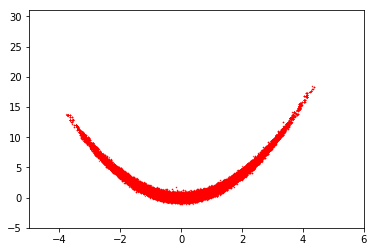

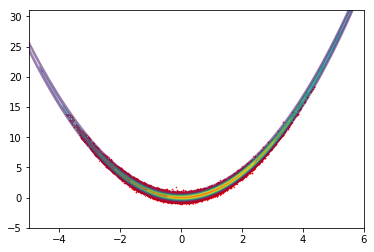

In [127]:
burnin_steps = 100

plt.scatter(chain.numpy()[burnin_steps:,:,0], chain.numpy()[burnin_steps:,:,1], s = 0.1, color = 'red')
plt.xlim(min(x), max(x))
plt.ylim(min(y), max(y))
plt.show()

plt.contour(x, y, L, levels = np.array([0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])*np.max(L.flatten()).astype(np.float64), alpha = 0.5)
plt.scatter(chain.numpy()[burnin_steps:,:,0], chain.numpy()[burnin_steps:,:,1], s = 0.1, color = 'red')
plt.show()